In [6]:
import torch
torch.cuda.empty_cache()

In [4]:
import os
import torch
import wget
import zipfile

data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = "CELEBA_DATASET"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)


In [34]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

CELEBA = []
path = "CELEBA_DATASET/img_align_celeba/"
for i in range(60000):
    img = cv2.imread(path+"%06d"%(i+1)+".jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    CELEBA.append(np.array(img))
CELEBA = np.array(CELEBA)
print(CELEBA.shape)

(60000, 128, 128, 3)


In [36]:
import torch
import numpy as np
import cv2
import wandb
import time
# import os

from denoising_diffusion_pytorch import Unet, GaussianDiffusion

# os.environ['WANDB_NOTEBOOK_NAME'] = "KJM"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)


# training_images = torch.rand(8, 3, 128, 128) # images are normalized from 0 to 1
CELEBA_images = CELEBA
training_images = torch.zeros(60000,3,128,128)
# print(MNIST_images.shape)
for i in range(60000):
    training_images[i] = torch.Tensor(CELEBA_images[i].transpose(2,0,1))/255.0
# print(training_images.shape)
# training_images = training_images.to(device)
# loss = diffusion(training_images)
# loss.backward()
# after a lot of training

# sampled_images = diffusion.sample(batch_size = 8)
# sampled_images.shape # (4, 3, 128, 128)

In [37]:
wandb.init(project='DiffusionCELEBA_test1',entity='jongminkim')
wandb.run.name = time.strftime('%Y%m%d_%H%M%S',time.localtime(time.time()))
wandb.watch(model)

starttime = time.time()
BATCH=32
optim = torch.optim.Adam(diffusion.parameters(), lr=3e-4)
print("start training")
for i in range(50000):
    i += 1
    idx = torch.randint(0,60000,(BATCH,), device='cpu')
    trnimg = training_images[idx].to(device)
    loss = diffusion(trnimg)
    # loss = diffusion(training_images)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 100 == 0:
        wandb.log({"loss": loss})
    if i % 500 == 0:
        print(str(i)+"th step : "+str(loss.item())+", time : "+str(time.time()-starttime))
    if i % 10000 == 0:
        torch.save(model.state_dict(), "weights/weights_CELEBA_"+str(i//1000)+"k_"+time.strftime('%m%d',time.localtime(time.time()))+".pt")
print("Total Elapsed Time : "+str(time.time()-starttime))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jongminkim. Use `wandb login --relogin` to force relogin


start training
500th step : 0.09816106408834457, time : 216.7074384689331
1000th step : 0.11840833723545074, time : 432.73313641548157
1500th step : 0.09179066121578217, time : 648.957968711853
2000th step : 0.12321148812770844, time : 866.905179977417
2500th step : 0.10370998084545135, time : 1085.1664757728577
3000th step : 0.0871179923415184, time : 1303.4326939582825
3500th step : 0.08365477621555328, time : 1521.6913495063782
4000th step : 0.09804078191518784, time : 1740.120684146881
4500th step : 0.08769115805625916, time : 1958.0547807216644
5000th step : 0.1067374050617218, time : 2174.276871442795
5500th step : 0.12058462202548981, time : 2390.3985171318054
6000th step : 0.08953668177127838, time : 2606.726578474045
6500th step : 0.07003454864025116, time : 2824.95982670784
7000th step : 0.07498394697904587, time : 3042.641845703125
7500th step : 0.07262805104255676, time : 3260.1562616825104
8000th step : 0.08385088294744492, time : 3477.8058915138245
8500th step : 0.1058692

In [44]:
starttime = time.time()
BATCH=32
optim = torch.optim.Adam(diffusion.parameters(), lr=3e-4)
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()
model.load_state_dict(torch.load("weights/weights_CELEBA_200k_0425.pt",map_location=device))
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)
print("start training")
for i in range(200000,400000):
    i += 1
    idx = torch.randint(0,60000,(BATCH,), device='cpu')
    optim.zero_grad()
    trnimg = training_images[idx].to(device)
    loss = diffusion(trnimg)
    loss.backward()
    optim.step()
    if i % 10000 == 0:
        print(str(i)+"th step : "+str(loss.item())+", time : "+str(time.time()-starttime))
    if i % 10000 == 0:
        torch.save(model.state_dict(), "weights/weights_CELEBA_"+str(i//1000)+"k_"+time.strftime('%m%d',time.localtime(time.time()))+".pt")
print("Total Elapsed Time : "+str(time.time()-starttime))

start training
210000th step : 0.08487629145383835, time : 4334.953339338303
220000th step : 0.08425046503543854, time : 8673.710518360138
230000th step : 0.09159683436155319, time : 12977.500826597214
240000th step : 0.07042409479618073, time : 17295.783555030823
250000th step : 0.10324712842702866, time : 21590.490752220154
260000th step : 0.09317466616630554, time : 25881.095232009888
270000th step : 0.08583998680114746, time : 30162.97553706169
280000th step : 0.09091103076934814, time : 34443.74615526199
290000th step : 0.09097951650619507, time : 38723.45241522789
300000th step : 0.07244652509689331, time : 43001.77004790306
310000th step : 0.09746819734573364, time : 47278.65858101845
320000th step : 0.08863165229558945, time : 51555.242993831635
330000th step : 0.10256769508123398, time : 55830.806594610214
340000th step : 0.08090642094612122, time : 60107.62425208092
350000th step : 0.06304888427257538, time : 64383.7018699646
360000th step : 0.06574473530054092, time : 68662.

In [45]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(device)
model.train()
model.load_state_dict(torch.load("weights/weights_CELEBA_400k_0426.pt",map_location=device))
diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to(device)

BSIZE = 32
sampled_images = diffusion.sample(batch_size = BSIZE)
print(sampled_images.shape)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([32, 3, 128, 128])


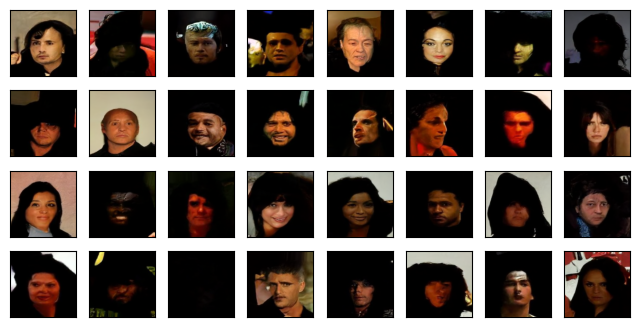

In [46]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

BB = (BSIZE+7)//8
fig = plt.figure(figsize = (8,BB))

for i in range(BSIZE):
    ax = fig.add_subplot(BB,8,i+1)
    img = (sampled_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    # ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.imshow(img)
    ax.set_xticks([]), ax.set_yticks([])

In [21]:
diffusion.objective

'pred_noise'

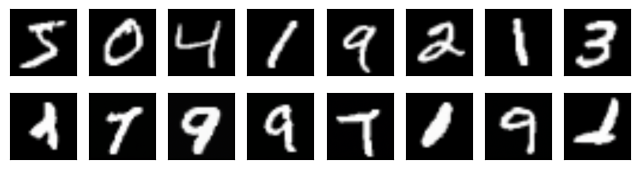

In [27]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig = plt.figure(figsize = (8,2))
for i in range(8):
    ax = fig.add_subplot(2,8,i+1)
    img = (training_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

for i in range(8):
    ax = fig.add_subplot(2,8,i+9)
    img = (sampled_images[i,:].to('cpu').squeeze(0).permute(1,2,0)).numpy()
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_xticks([]), ax.set_yticks([])

#plt.show()